In [ ]:
%cd ..

In [2]:
from pathlib import Path
import json
from typing import Any, Union
import shutil

import numpy as np
import cv2

import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision.io import read_image, write_png
from torchvision import transforms
from torchvision.transforms import functional as VF, InterpolationMode

from tire_vision.thread.spikes.pipeline import SpikePipeline
from tire_vision.config import SpikePipelineConfig, CLASS_COLORS, CLASS_MAPPING


images_dir = Path("data/dataset_crop")
labels_path = Path("data/result.json")
device = "cuda"

In [3]:
with open(labels_path, "r") as f:
    seg_labels = json.load(f)

for i in range(len(seg_labels["images"])):
    name = seg_labels["images"][i]["file_name"]
    name = images_dir / name.split("__")[-1]
    seg_labels["images"][i]["file_name"] = name

In [4]:
cfg = SpikePipelineConfig()
cfg.device = "cuda"
cfg.detection_threshold = 0.5
cfg.erosion_iterations = 0

In [5]:
pipeline = SpikePipeline(cfg)

In [6]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        labels: dict,
        prune_empty: bool = True,
        image_transform: nn.Module = None,
    ):
        self.labels = labels
        self.image_transform = image_transform

        for img in labels["images"]:
            assert Path(img["file_name"]).exists()

        images = [None] * len(self.labels["images"])
        annotations = [[] for _ in range(len(self.labels["images"]))]

        for image in labels["images"]:
            images[image["id"]] = image["file_name"]

        for annotation in labels["annotations"]:
            annotations[annotation["image_id"]].append(
                {
                    "poly": np.array(
                        annotation["segmentation"], dtype=np.int32
                    ).reshape(-1, 2),
                    "category": annotation["category_id"] + 1,
                }
            )

        self.images = images
        self.annotations = annotations

        if prune_empty:
            ids = [i for i in range(len(self.labels["images"])) if annotations[i]]
            self.images = [self.images[i] for i in ids]
            self.annotations = [self.annotations[i] for i in ids]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):
        image = read_image(self.images[idx]) / 255.0
        image_name = Path(self.images[idx]).name
        if self.image_transform:
            image = self.image_transform(image)

        return image.contiguous(), image_name


transform_image = transforms.Compose(
    [
        transforms.Resize((512, 512), interpolation=InterpolationMode.BICUBIC),
    ]
)

In [7]:
def add_annotations(image: np.ndarray, annotations: list[dict[str, Any]]) -> np.ndarray:
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for annotation in annotations:
        x, y, w, h = annotation["box"]
        class_name = CLASS_MAPPING[annotation["class"]]
        color = CLASS_COLORS[class_name]
        cv2.rectangle(image_bgr, (x, y), (x + w, y + h), color, 2)
        cv2.putText(
            image_bgr, class_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
        )

    return image_bgr

In [8]:
dataset = SegmentationDataset(seg_labels)

In [9]:
image, name = dataset[0]

result = pipeline(image)

result = list(filter(lambda x: x["box"][0] < 450 or x["box"][0] > 600, result))
result = list(filter(lambda x: x["box"][0] > 160 and x["box"][0] < 930, result))

In [13]:
import json

result_full = {}
result_full["spikes"] = result
result_full["bad_count"] = 12
result_full["good_count"] = 14

with open("result_full.json", "w") as f:
    json.dump(result_full, f, indent=4)

from pprint import pprint

pprint(result_full)

{'bad_count': 12,
 'good_count': 14,
 'spikes': [{'box': (309, 39, 32, 32), 'class': 0},
            {'box': (408, 69, 32, 32), 'class': 0},
            {'box': (835, 74, 32, 32), 'class': 0},
            {'box': (263, 92, 32, 32), 'class': 0},
            {'box': (782, 123, 32, 32), 'class': 0},
            {'box': (256, 149, 32, 32), 'class': 0},
            {'box': (681, 158, 32, 32), 'class': 1},
            {'box': (313, 212, 32, 32), 'class': 0},
            {'box': (759, 257, 32, 32), 'class': 0},
            {'box': (411, 265, 32, 32), 'class': 1},
            {'box': (850, 332, 32, 32), 'class': 0},
            {'box': (331, 393, 32, 32), 'class': 0},
            {'box': (716, 432, 32, 32), 'class': 1},
            {'box': (795, 427, 32, 32), 'class': 0},
            {'box': (275, 499, 32, 32), 'class': 0},
            {'box': (247, 542, 32, 32), 'class': 0},
            {'box': (887, 624, 32, 32), 'class': 0},
            {'box': (816, 763, 32, 32), 'class': 1},
            {

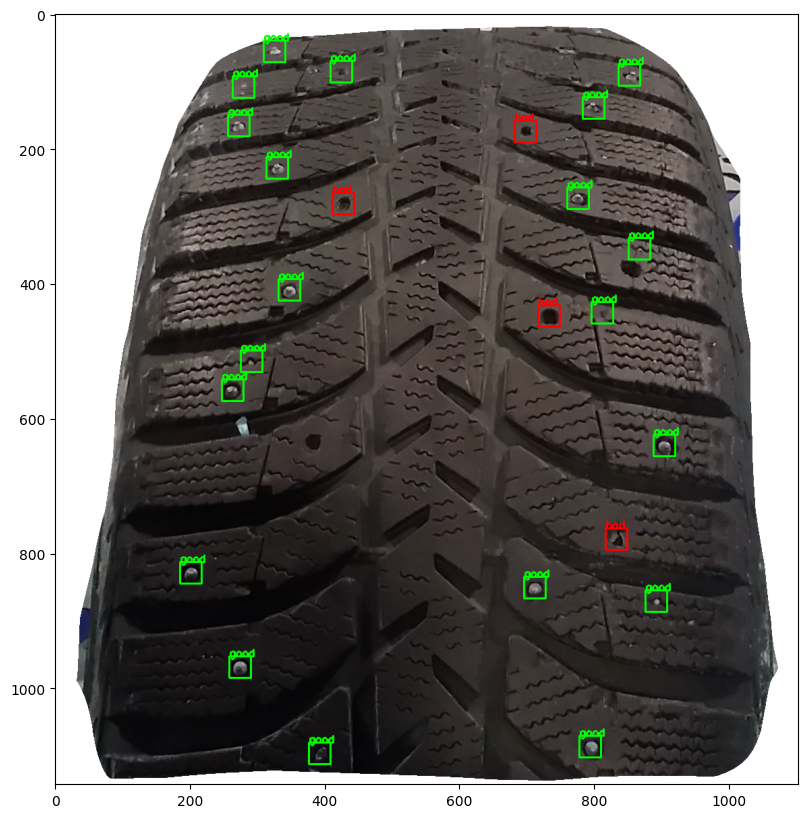

In [16]:
img_annotated = add_annotations(
    (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8), result
)

plt.figure(figsize=(10, 10))
plt.imshow(img_annotated)
plt.show()

In [17]:
image.max()

tensor(1.)

In [18]:
cv2.imwrite("tmp.jpg", cv2.cvtColor(img_annotated, cv2.COLOR_RGB2BGR))

True

In [12]:
def get_crop(image: torch.Tensor, cx: int, cy: int, crop_size: int = 128):
    """
    Get a crop from the image. If crop is out of bounds, will be padded with zeros to an appropriate size.

    Args:
        image: torch.Tensor, shape (C, H, W), dtype=torch.uint8
        cx: int, x-coordinate of the center of the crop
        cy: int, y-coordinate of the center of the crop
        crop_size: int, size of the crop

    Returns:
        crop: torch.Tensor, shape (C, crop_size, crop_size), dtype=torch.uint8
    """
    h, w = image.shape[1:]
    x1 = cx - crop_size // 2
    x2 = x1 + crop_size
    y1 = cy - crop_size // 2
    y2 = y1 + crop_size

    crop = image[
        :,
        max(0, y1) : min(h, y2),
        max(0, x1) : min(w, x2),
    ]

    if crop.shape[1] != crop_size or crop.shape[2] != crop_size:
        pad_x1 = 0 if x1 >= 0 else -x1
        pad_x2 = 0 if x2 <= w else x2 - w
        pad_y1 = 0 if y1 >= 0 else -y1
        pad_y2 = 0 if y2 <= h else y2 - h
        crop = F.pad(crop, (pad_x1, pad_x2, pad_y1, pad_y2))

    return crop


save_data_path = Path("data/spike_classification")


if save_data_path.exists():
    shutil.rmtree(save_data_path)

save_data_path.mkdir(parents=True, exist_ok=True)


def get_spike_crops(
    input_image: torch.Tensor,
    image_name: str,
    pipeline: SpikePipeline,
    save_data_path: Union[Path, str],
    crop_size: int = 128,
    add_rectangular_annotation: bool = True,
):
    result = pipeline(input_image)

    save_data_path = Path(save_data_path)
    data = []
    for i, spike in enumerate(result):
        x, y, w, h = spike["box"]
        crop = (
            get_crop(input_image, x + w // 2, y + h // 2, crop_size)
            .permute(1, 2, 0)
            .numpy()
        )
        crop = (crop * 255).astype(np.uint8)

        if add_rectangular_annotation:
            annot_x, annot_y = crop_size // 2 - w // 2, crop_size // 2 - h // 2

            crop_bgr = cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)
            crop_bgr = cv2.rectangle(
                crop_bgr, (annot_x, annot_y), (annot_x + w, annot_y + h), (255, 0, 0), 2
            )
            crop = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)

        save_path = save_data_path / f"{Path(image_name).stem}_spike{i}.png"
        data.append(
            {
                "image_name": str(image_name),
                "spike": spike,
                "crop_path": str(save_path),
            }
        )
        cv2.imwrite(save_path, crop)

    return data

In [13]:
data = []
for i in range(len(dataset)):
    image, name = dataset[i]
    data.extend(
        get_spike_crops(
            image,
            name,
            pipeline,
            save_data_path,
            crop_size=128,
            add_rectangular_annotation=True,
        )
    )

In [16]:
save_path = save_data_path / "metadata.json"
with open(save_path, "w") as f:
    json.dump(data, f)